In [2]:
%load_ext autoreload
%autoreload 2
# %config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json
import matplotlib as mpl

In [4]:
from surp import subgiants, vincenzo2021
from surp import VICE_Model
from surp import yields
from surp import analysis
from surp import gce_math as gcem

import arya

In [18]:
all_abundances = pd.read_csv("../notebooks/data_analysis/all_data.csv")

filt = ~np.isnan(subgiants["C_MG"])
filt &= ~np.isnan(subgiants["MG_H"])
filt &= subgiants["high_alpha"]
subgiants_ha = subgiants[filt]

fiducial = VICE_Model("../out/C11_f0.2.json")

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

In [7]:
def sfh(tau=3):
    return lambda t: np.exp(-t/tau)

def sz_model(eta=6.2, tau_star=16.1, t_end=5.4, tau_sfh=1, dt=0.005):
    sz = vice.singlezone(elements=["o", "mg", "c", "fe"], dt=dt, eta=eta, func=sfh(tau=tau_sfh), mode="ifr", tau_star=tau_star, Mg0=0)
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out

In [8]:
yields.set_yields(f_agb=0.2)# mass_factor=1.5, no_negative=False, f_agb=0.25, xi=0)

y_mg = vice.yields.ccsne.settings["mg"]
def y_mod3(Z):
    mh = gcem.Z_to_MH(np.maximum(Z, gcem.MH_to_Z(-4)))
    return y_mg*(
        1*(mh + 1.5)**2 + 0*(Z-gcem.Z_SUN)+ 1.25
    )



# vice.yields.ccsne.settings["c"] = y_mod3
y_cc_c = vice.yields.ccsne.settings["c"]
yo = vice.yields.ccsne.settings["o"]


yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 5.28e-02 (Z-Z0),    1.36 × cristallo11             0                              
                    Z>=-1.00e+00; 8.67e-04 +                                                                     
                    0.00e+00 Z, else                                                                             

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model

/users/PAS2232/aeyobd/surp/surp/gce_math.py:60: RuntimeWarning: invalid value encountered in log10
  return np.log10(data) - np.log10(vice.solar_z(ele) / vice.solar_z(ele2))


ZeroDivisionError: division by zero

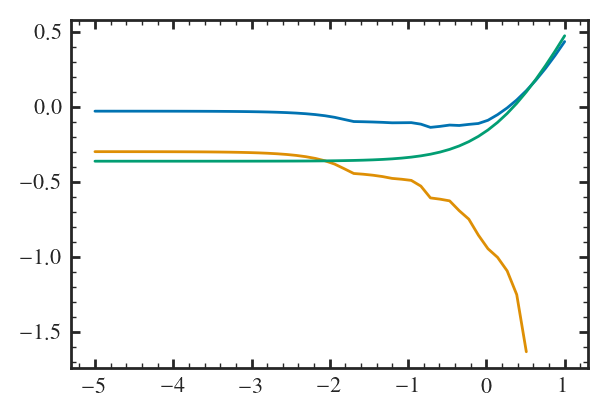

In [11]:
MoverH = np.linspace(-5, 1)
Z = gcem.MH_to_Z(MoverH)

y_total = []
for mh in MoverH:
    yc, times = vice.single_stellar_population("c", Z=gcem.MH_to_Z(mh))
    y_total.append(yc[-1]/1e6)
    
    
y_total = np.array(y_total)

plt.plot(MoverH, gcem.abund_to_brak(y_total/yo, "c", "o"), label="Total")
plt.plot(MoverH,
    gcem.abund_to_brak((y_total-[y_cc_c(x) for x in Z])/yo, "c", "o")
     , label="AGB")
plt.plot(MoverH, gcem.abund_to_brak([y_cc_c(x)/yo for x in Z], "c", "o"), label="CCSNe")


df = subgiants[~subgiants.high_alpha]
arya.medianplot(df, x="MG_H", y="C_MG", binsize=200, stat="median", errorbar=None, aes="line", label="data")

arya.Legend(color_only=True, loc=-1)
plt.xlabel("[M/H]")
plt.ylabel("[C/O]")
plt.ylim(-0.75, 0.25)
plt.xlim(-5, 1)

/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/singlezone/singlezone.py:269: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity #for asymptotic giant branch star yields may significantly increase the #required integration time, especially for fine #timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64

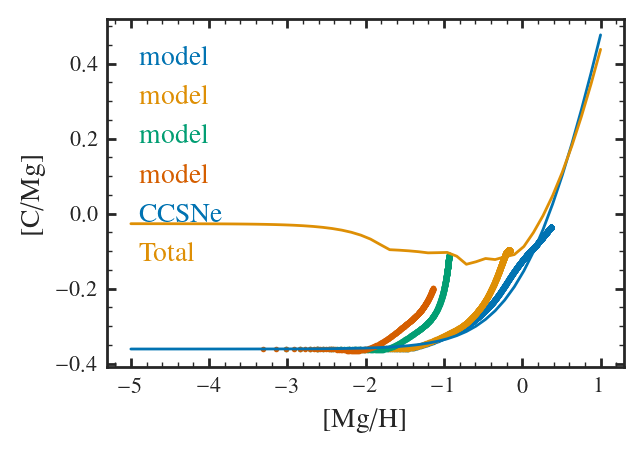

In [15]:
sz_models = [
    sz_model(eta=0, t_end=13, tau_star=2, tau_sfh=5),
    sz_model(eta=1, t_end=10, tau_star=2, tau_sfh=10),
    sz_model(eta=9, t_end=3, tau_star=5, tau_sfh=3),
    sz_model(eta=12, t_end=2, tau_star=10, tau_sfh=2),
    # sz_model(eta=15, t_end=5, tau_sfh=1)
]

for model in sz_models:
    plt.scatter(model.history["[o/h]"], model.history["[c/o]"], label="model", s=1)



plt.plot(MoverH, [gcem.abund_to_brak(y_cc_c(x)/yo, "c", "o") for x in Z], label="CCSNe")
plt.plot(MoverH, gcem.abund_to_brak(y_total/yo, "c", "o"), label="Total")



plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

arya.Legend(color_only=True)

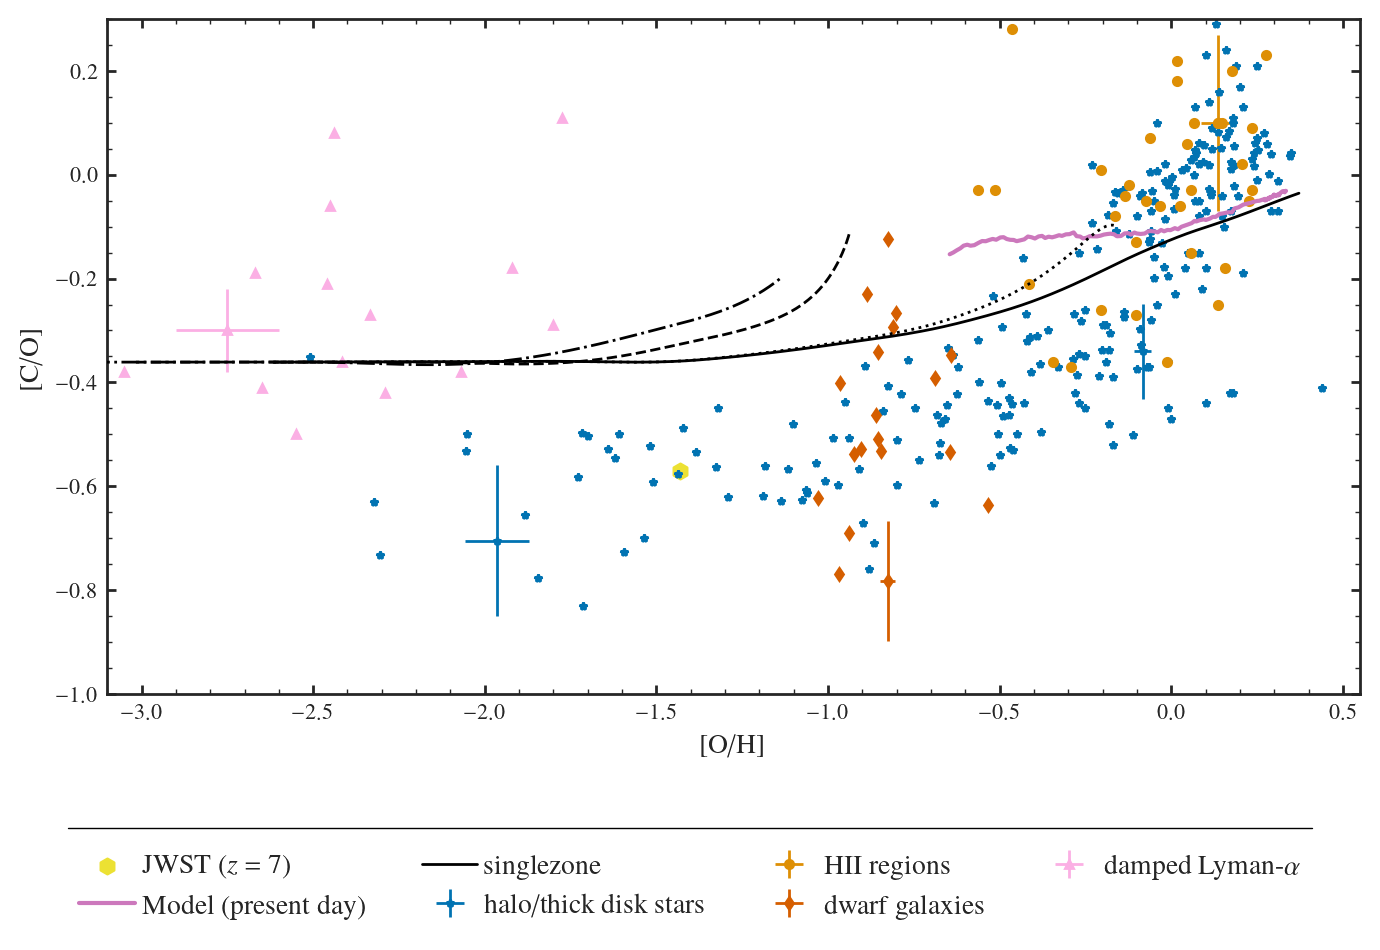

In [19]:
fig = plt.figure(figsize=(7, 4))

for i in [2,0,1,3]:
    label = ["HII regions", "dwarf galaxies", "halo/thick disk stars", "damped Lyman-$\\alpha$"][i]
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    eb = np.isin(df.index, [68, 36, 2, 82, 239])
    plt.errorbar(df["[o/h]"], df["[c/o]"], 
                 xerr=eb*df["[o/h]_err"], yerr=eb*df["[c/o]_err"], label=label, 
               fmt=["o", "d", "*", "^"][i], ms=3, 
               color=arya.style.COLORS[[1, 3, 0, 6][i]], capsize=0)
    
    

plt.plot()

plt.ylim(-1, 0.3)
plt.xlim(-3.1, 0.55)

lab = plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")

plt.scatter([-1.43], [-0.57], marker="h", s=30, label="JWST ($z=7$)", color=arya.style.COLORS[8])


fiducial.plot_gas("[o/h]", "[c/o]", label="Model (present day)", plot_data=False, zorder=3, lw=1.5, color=arya.style.COLORS[4])

# fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model ($t=2$ Gyr)", zorder=3, lw=2, color=arya.style.COLORS[4])

for i in range(len(sz_models)):
    out = sz_models[i]
    if i == 0:
        label="singlezone"
    else:
        label=""
    plt.plot(out.history["[o/h]"], out.history["[c/o]"], label=label, color="k", 
             lw=1, zorder=4, ls=["-", ":", "--", "-."][i])





    

leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4)
box1 = leg.get_tightbbox()
box2 = lab.get_tightbbox() 


t1 = box1.transformed(fig.transFigure.inverted())
t2 = box2.transformed(fig.transFigure.inverted())
ym = (t2.y0 + t1.y1)/2


fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))


plt.xlabel(r"[O/H]")
plt.ylabel(r"[C/O]")
plt.tight_layout()

plt.savefig("figures/summary.pdf")

# Extra

In [6]:
amarsi19 = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)
amarsi19["[o/h]"] = amarsi19["[O/H]3N"]
amarsi19["[c/h]"] = amarsi19["[C/H]3N"]
amarsi19["[c/o]"] = amarsi19["[c/h]"] - amarsi19["[o/h]"] 

amarsi19["[o/h]_err"] = amarsi19["e_[O/H]3N"]
amarsi19["[c/h]_err"] = amarsi19["e_[C/H]3N"]
amarsi19["[c/o]_err"] = amarsi19["[o/h]_err"] + amarsi19["[c/h]_err"] 
amarsi19["[o/fe]"] = -amarsi19["[Fe/H]3L"] + amarsi19["[o/h]"]
amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

/tmp/slurmtmp.24868848/ipykernel_140677/3032376907.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amarsi19 = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)


Text(0, 0.5, '[c/o]')

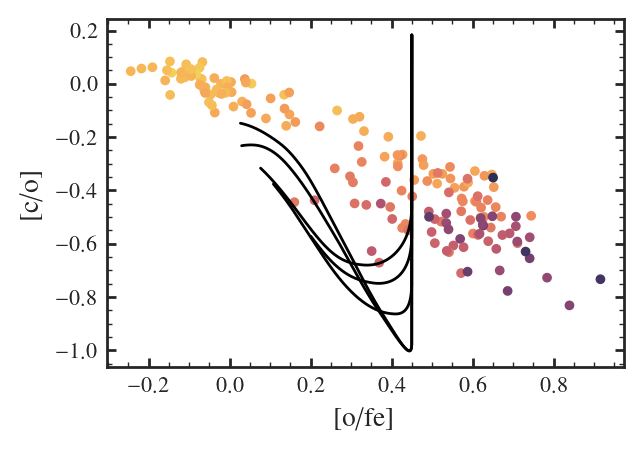

In [67]:
for i in range(len(sz_models)):
    out = sz_models[i]
    if i == 0:
        label="singlezone"
    else:
        label=""
    plt.plot(out.history["[o/fe]"], out.history["[c/o]"], label=label, color="k", lw=1, zorder=4)
    
plt.scatter(amarsi19["[o/fe]"], amarsi19["[c/o]"], c=amarsi19["[o/h]"])

plt.xlabel("[o/fe]")
plt.ylabel("[c/o]")

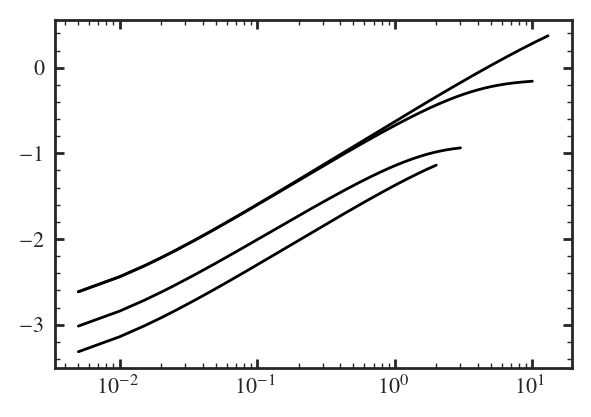

In [13]:
for i in range(len(sz_models)):
    out = sz_models[i]
    if i == 0:
        label="singlezone"
    else:
        label=""
    plt.plot(out.history["time"], out.history["[o/h]"], label=label, color="k", lw=1, zorder=4)

plt.xscale("log")

In [14]:
import surp

In [15]:
surp.analysis.bracket_to_abundance(-0.5, "c", "mg") / 0.6

2.6627226199629423

/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity #for asymptotic giant branch star yields may significantly increase the #required integration time, especially for fine #timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/outputs/output.py:131: UserWarning: agb c yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)


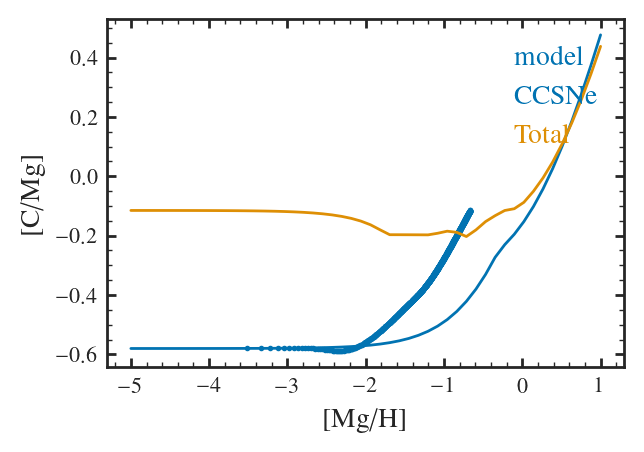

In [16]:
sz_models = [
    sz_model(eta=9, t_end=5.4, tau_star=16, tau_sfh=1),
    # sz_model(eta=40, t_end=2, tau_star=40, tau_sfh=1),
    #sz_model(eta=15, t_end=1, tau_star=10, tau_sfh=5),
    #sz_model(eta=5, t_end=0.3, tau_star=2, tau_sfh=50),
    # sz_model(eta=15, t_end=5, tau_sfh=1)
]

for model in sz_models:
    plt.scatter(model.history["[o/h]"], model.history["[c/o]"], label="model", s=1)



plt.plot(MoverH, analysis.abundance_to_bracket(y_cc_c(Z)/yo, "c", "o"), label="CCSNe")
plt.plot(MoverH, analysis.abundance_to_bracket(y_total/yo, "c", "o"), label="Total")



plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

arya.Legend(color_only=True)